In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
# from sklearn import SVM
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.tree.export import export_graphviz
from sklearn.externals.six import StringIO  

C:\Python\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.tree.export module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Python\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


# Data exploration

In [2]:
#path to directory with the relevant files
path_dir = r'..\dataset'
fname = 'final_dataset'
file_path = (os.path.join(path_dir, fname))
df = pd.read_csv(file_path,  engine = 'python' )

In [3]:
# explore the data
df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,0,1,2,3,4,5,6,...,174,175,176,177,178,179,device,asym,num_peaks,Q
0,0,0,0,13.723515,-0.728629,-12.483423,1.688098,9.888614,-2.080968,-6.681533,...,-0.001162,0.000104,0.000681,0.000552,-0.000346,-0.001278,fbg,2.822111,1,6829.429046
1,1,0,0,11.469369,-6.352077,-0.006682,0.370258,1.178802,-0.449753,-0.147980,...,-0.003236,0.002370,-0.002129,-0.001926,-0.000807,-0.005789,fbg,0.742727,1,7223.116034
2,2,0,0,9.615106,-6.869292,1.914732,0.731908,-0.577569,-0.083338,0.113260,...,0.012563,-0.046946,0.010126,0.059438,-0.050124,-0.042446,fbg,0.415773,1,6902.941217
3,3,0,0,21.564599,-16.958455,8.033247,-1.398305,-0.575436,0.038131,0.151038,...,-0.000088,-0.000094,-0.000092,-0.000088,-0.000098,-0.000087,fbg,0.983101,1,1630.158028
4,4,0,0,10.607961,-8.419459,4.361642,-0.784203,-0.840003,0.674981,-0.044114,...,-0.000603,-0.001028,-0.001444,-0.000508,-0.000681,-0.001837,fbg,0.860707,1,5849.494425


In [4]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', '0', '1', '2', '3', '4',
       '5', '6',
       ...
       '174', '175', '176', '177', '178', '179', 'device', 'asym', 'num_peaks',
       'Q'],
      dtype='object', length=187)

In [5]:
df.num_peaks.value_counts()

1    125
3     21
4     20
8      8
2      8
5      4
7      2
6      1
Name: num_peaks, dtype: int64

In [6]:
df.device.value_counts()

qpfs                        75
ring_resonator_multimode    65
fbg                         49
Name: device, dtype: int64

In [7]:
# simplify peak designation, you either are going to see one peak or multiple depending upon the class
for i in range(df.num_peaks.count()):
    if df.num_peaks[i] != 1:
        df.num_peaks[i] = 2

C:\Python\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [8]:
# normalize Q variable
mean_q = df['Q'].mean()
std_q = df['Q'].std()
df['q_scale'] = (df['Q'] - mean_q)/std_q

In [9]:
# clean up data
print(df.isna().sum())
df = df.fillna(0)
df = df.iloc[:,3:]
df.drop('Q', axis=1, inplace =True)

#  df.drop('Unnamed: 0', axis=1, inplace =True)
# df.drop('Unnamed: 0.1', axis=1, inplace =True)
# df.drop('Unnamed: 0.1.1', axis=1, inplace =True)

Unnamed: 0        0
Unnamed: 0.1      0
Unnamed: 0.1.1    0
0                 0
1                 0
                 ..
device            0
asym              0
num_peaks         0
Q                 0
q_scale           0
Length: 188, dtype: int64


In [10]:
# df.iloc[:,0:10]
df.head()

,0,1,2,3,4,5,6,7,8,9,...,174,175,176,177,178,179,device,asym,num_peaks,q_scale
0,13.723515,-0.728629,-12.483423,1.688098,9.888614,-2.080968,-6.681533,1.885390,3.472349,-1.238911,...,-0.001162,0.000104,0.000681,0.000552,-0.000346,-0.001278,fbg,2.822111,1,-0.639499
1,11.469369,-6.352077,-0.006682,0.370258,1.178802,-0.449753,-0.147980,-0.207228,-0.147831,0.161478,...,-0.003236,0.002370,-0.002129,-0.001926,-0.000807,-0.005789,fbg,0.742727,1,-0.557370
2,9.615106,-6.869292,1.914732,0.731908,-0.577569,-0.083338,0.113260,-0.021328,0.016898,0.019467,...,0.012563,-0.046946,0.010126,0.059438,-0.050124,-0.042446,fbg,0.415773,1,-0.624163
3,21.564599,-16.958455,8.033247,-1.398305,-0.575436,0.038131,0.151038,-0.001294,-0.008540,-0.015440,...,-0.000088,-0.000094,-0.000092,-0.000088,-0.000098,-0.000087,fbg,0.983101,1,-1.724132
4,10.607961,-8.419459,4.361642,-0.784203,-0.840003,0.674981,-0.044114,-0.183478,0.077214,0.015140,...,-0.000603,-0.001028,-0.001444,-0.000508,-0.000681,-0.001837,fbg,0.860707,1,-0.843925


In [11]:
df.shape

(189, 184)

In [12]:
# sns.pairplot(df)

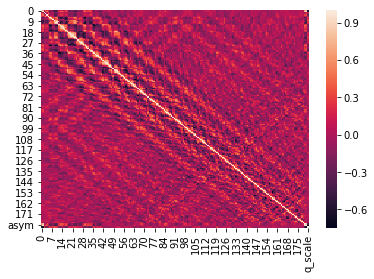

In [13]:
sns.heatmap(df.corr()[::1])

how do i figure out which columns to ignore?

In [14]:
df.q_scale

0     -0.639499
1     -0.557370
2     -0.624163
3     -1.724132
4     -0.843925
         ...   
184    0.132485
185   -1.819782
186   -1.364425
187   -1.743910
188   -1.587837
Name: q_scale, Length: 189, dtype: float64

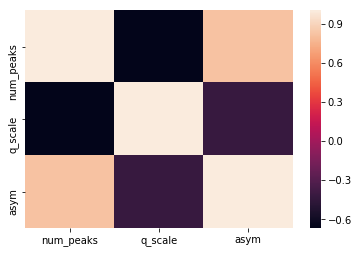

In [15]:
features =['num_peaks', 'q_scale', 'device', 'asym']   
sns.heatmap(df[features].corr())

# data preparation 

features are limited to peak characterisitics only

In [16]:
# define the X and y axis
# X1 = df.drop(columns = ['device'])
X1 = df[['q_scale', 'asym','num_peaks']]
y1 = df.device

X_testing, X_validation, y_testing, y_validation = train_test_split(X1,y1, test_size = 0.30, random_state=42)
X, y = X_testing, y_testing
X.shape

(132, 3)

In [17]:
y_validation.value_counts()


qpfs                        23
ring_resonator_multimode    17
fbg                         17
Name: device, dtype: int64

# Running models

# run a KNN mode with gridsearch

In [18]:
# run a baseline model with no optimization

clf = KNeighborsClassifier()
clf.fit(X,y)
y_pred = clf.predict(X_validation)

In [19]:
print('null accuracy is {} '.format(y.value_counts().head(1)/len(y)))
print(metrics.accuracy_score(y_validation, y_pred))
print(metrics.recall_score(y_validation, y_pred, average =  'micro'))
print(metrics.precision_score(y_validation, y_pred, average='micro'))
print(metrics.f1_score(y_validation, y_pred, average='micro'))
#tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
#print('TN:{} | FP:{} | FN:{} | TP:{}'.format(tn, fp, fn, tp))
print(metrics.classification_report(y_validation, y_pred))

null accuracy is qpfs    0.393939
Name: device, dtype: float64 
1.0
1.0
1.0
1.0
                          precision    recall  f1-score   support

                     fbg       1.00      1.00      1.00        17
                    qpfs       1.00      1.00      1.00        23
ring_resonator_multimode       1.00      1.00      1.00        17

                accuracy                           1.00        57
               macro avg       1.00      1.00      1.00        57
            weighted avg       1.00      1.00      1.00        57



In [20]:
# optimize hyperparameters for a KNN modes

In [21]:
# cross-validation process using Pipeline
from sklearn.model_selection import cross_val_score

pipe = make_pipeline(KNeighborsClassifier(n_neighbors=3))

cv_scores =[]
k_val =[]
k_range = list(range(3,30))
for k in k_range:
    score = cross_val_score(pipe, X, y, cv=k, scoring='accuracy').mean()
    k_val.append(k)
    cv_scores.append(score)
ls = list(zip(k_val, cv_scores))
print(ls)
# cross_val_score(pipe, X, y, cv=5, scoring='accuracy').mean()

[(3, 0.9924242424242425), (4, 0.9924242424242424), (5, 0.9923076923076923), (6, 0.9924242424242425), (7, 0.9920634920634921), (8, 0.9921875), (9, 0.9920634920634921), (10, 0.9923076923076923), (11, 0.9924242424242423), (12, 0.9924242424242423), (13, 0.9923076923076923), (14, 0.9920634920634921), (15, 0.9916666666666667), (16, 0.9921875), (17, 0.9915966386554622), (18, 0.9920634920634921), (19, 0.9924812030075189), (20, 0.9916666666666666), (21, 0.992063492063492), (22, 0.9924242424242423), (23, 0.991304347826087), (24, 0.9916666666666667), (25, 0.992), (26, 0.9923076923076923), (27, 0.9925925925925926), (28, 0.9910714285714286), (29, 0.9913793103448276)]


In [22]:
np.argmax(cv_scores)

24

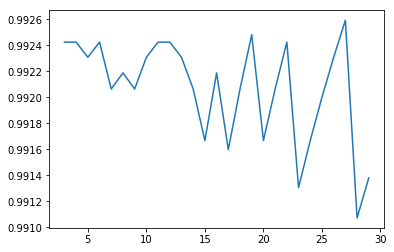

In [23]:
plt.plot(k_val, cv_scores)

we chose k=5 

In [24]:
# %time   # I am using it wrong
# create a pipeline
pipe = make_pipeline(KNeighborsClassifier(n_neighbors=3))

# search for an optimal n_neighbors value using GridSearchCV
neighbors_range = list(range(2, 25))

# search or an optimal weigth parameter HOW DO I INTEGRATE THAT IN?
weight_range = ['uniform', 'distance']

# search for an optimal leaf size
leaf_range = list(range(1,50))

# search for an optimal metric range
metric_range = ['minkowski', 'manhattan']
#create a param grid
param_grid = dict(kneighborsclassifier__n_neighbors=neighbors_range,kneighborsclassifier__leaf_size=leaf_range,
                  kneighborsclassifier__metric=metric_range)

# create a grid search
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='f1_micro')
i
# fit the grid
grid.fit(X, y)

# view the best_score_ and best_params_
print(grid.best_score_)
print(grid.best_params_)

0.9923076923076923
{'kneighborsclassifier__leaf_size': 1, 'kneighborsclassifier__metric': 'minkowski', 'kneighborsclassifier__n_neighbors': 2}


In [25]:
knn = KNeighborsClassifier(n_neighbors = 2, metric = 'minkowski', leaf_size = 1, weights='distance')
knn.fit(X,y)
y_pred = knn.predict(X_validation)
print('null accuracy is {} '.format(y.value_counts().head(1)/len(y)))
print(metrics.accuracy_score(y_validation, y_pred))
print(metrics.recall_score(y_validation, y_pred, average =  'micro'))
print(metrics.precision_score(y_validation, y_pred, average='micro'))
print(metrics.f1_score(y_validation, y_pred, average='micro'))
#tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
#print('TN:{} | FP:{} | FN:{} | TP:{}'.format(tn, fp, fn, tp))
print(metrics.classification_report(y_validation, y_pred))
%time

null accuracy is qpfs    0.393939
Name: device, dtype: float64 
0.9824561403508771
0.9824561403508771
0.9824561403508771
0.9824561403508771
                          precision    recall  f1-score   support

                     fbg       1.00      0.94      0.97        17
                    qpfs       1.00      1.00      1.00        23
ring_resonator_multimode       0.94      1.00      0.97        17

                accuracy                           0.98        57
               macro avg       0.98      0.98      0.98        57
            weighted avg       0.98      0.98      0.98        57

Wall time: 0 ns


In [26]:
# test to see if changing CV value makes much of a difference

In [27]:
# create a pipeline
pipe = make_pipeline(KNeighborsClassifier(n_neighbors=3))

# search for an optimal n_neighbors value using GridSearchCV
neighbors_range = list(range(2, 25))

# search or an optimal weigth parameter
weight_range = ['uniform', 'distance']

# search for an optimal leaf size
leaf_range = list(range(1,50))

# search for an optimal metric range
metric_range = ['minkowski', 'manhattan']
#create a param grid
param_grid = dict(kneighborsclassifier__n_neighbors=neighbors_range,kneighborsclassifier__leaf_size=leaf_range, kneighborsclassifier__metric=metric_range)

# create a grid search
grid = GridSearchCV(pipe, param_grid, cv=10, scoring='f1_micro')
i
# fit the grid
grid.fit(X, y)

# view the best_score_ and best_params_
print(grid.best_score_)
print(grid.best_params_)

0.9923076923076923
{'kneighborsclassifier__leaf_size': 1, 'kneighborsclassifier__metric': 'minkowski', 'kneighborsclassifier__n_neighbors': 2}


In [28]:
knn = KNeighborsClassifier(n_neighbors =2, metric = 'minkowski', leaf_size = 1, weights='distance')
knn.fit(X,y)
y_pred = knn.predict(X_validation)
print('null accuracy is {} '.format(y.value_counts().head(1)/len(y)))
print(metrics.accuracy_score(y_validation, y_pred))
print(metrics.recall_score(y_validation, y_pred, average =  'micro'))
print(metrics.precision_score(y_validation, y_pred, average='micro'))
print(metrics.f1_score(y_validation, y_pred, average='micro'))
#tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
#print('TN:{} | FP:{} | FN:{} | TP:{}'.format(tn, fp, fn, tp))
print(metrics.classification_report(y_validation, y_pred))

null accuracy is qpfs    0.393939
Name: device, dtype: float64 
0.9824561403508771
0.9824561403508771
0.9824561403508771
0.9824561403508771
                          precision    recall  f1-score   support

                     fbg       1.00      0.94      0.97        17
                    qpfs       1.00      1.00      1.00        23
ring_resonator_multimode       0.94      1.00      0.97        17

                accuracy                           0.98        57
               macro avg       0.98      0.98      0.98        57
            weighted avg       0.98      0.98      0.98        57



In [29]:
# changing CV value doesn't make a big difference

cv = 5 gives slightly better results while being computationally less demanding, i.e. 5 less folds

# Let's now build a KNN model using pipeline and randomized search grid

In [30]:
%time
# create a pipeline
pipe = make_pipeline(KNeighborsClassifier(n_neighbors=3))

# search for an optimal n_neighbors value using GridSearchCV
neighbors_range = list(range(2, 25))

# search or an optimal weigth parameter
weight_range = ['uniform', 'distance']

# search for an optimal leaf size
leaf_range = list(range(1,50))

# search for an optimal metric range
metric_range = ['minkowski', 'manhattan']

# specify "parameter distributions"
param_dist = dict(n_neighbors=neighbors_range, leaf_size = leaf_range, metric = metric_range,weights=weight_range)

rand = RandomizedSearchCV(knn, param_dist, cv=10, scoring='f1_micro',
                          n_iter=200, random_state=5, return_train_score=True)
rand.fit(X, y)
rand.cv_results_

Wall time: 0 ns


{'mean_fit_time': array([0.00325003, 0.00174999, 0.00312004, 0.00311995, 0.00442004,
        0.00280008, 0.00256004, 0.00231001, 0.00156   , 0.00312002,
        0.00312004, 0.00311999, 0.00311997, 0.00025001, 0.00156   ,
        0.00156   , 0.        , 0.00156   , 0.        , 0.00231001,
        0.00537   , 0.00300004, 0.00306003, 0.00155997, 0.00331001,
        0.00350006, 0.00362   , 0.002     , 0.00281003, 0.00372005,
        0.0022501 , 0.00025001, 0.        , 0.00322001, 0.00311999,
        0.00387001, 0.00249999, 0.00174997, 0.00311999, 0.00175011,
        0.00250001, 0.00281007, 0.00311999, 0.00231006, 0.00119998,
        0.00250003, 0.00250003, 0.00325007, 0.00250006, 0.00325   ,
        0.0022501 , 0.00312002, 0.00311999, 0.00156002, 0.00181003,
        0.00250003, 0.00475016, 0.0029001 , 0.00250001, 0.00250001,
        0.00250003, 0.00249996, 0.00300004, 0.00281003, 0.00230999,
        0.00250001, 0.00250008, 0.00150006, 0.        , 0.00331006,
        0.00325005, 0.00245004,

In [31]:
# examine the best model
print(rand.best_score_)
print(rand.best_params_)

0.9923076923076923
{'weights': 'distance', 'n_neighbors': 15, 'metric': 'minkowski', 'leaf_size': 31}


In [32]:
knn = KNeighborsClassifier(n_neighbors =15, metric = 'minkowski', leaf_size = 31, weights='distance')
knn.fit(X,y)
y_pred = knn.predict(X_validation)
print('null accuracy is {} '.format(y.value_counts().head(1)/len(y)))
print(metrics.accuracy_score(y_validation, y_pred))
print(metrics.recall_score(y_validation, y_pred, average =  'micro'))
print(metrics.precision_score(y_validation, y_pred, average='micro'))
print(metrics.f1_score(y_validation, y_pred, average='micro'))
#tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
#print('TN:{} | FP:{} | FN:{} | TP:{}'.format(tn, fp, fn, tp))
print(metrics.classification_report(y_validation, y_pred))

null accuracy is qpfs    0.393939
Name: device, dtype: float64 
0.9824561403508771
0.9824561403508771
0.9824561403508771
0.9824561403508771
                          precision    recall  f1-score   support

                     fbg       1.00      0.94      0.97        17
                    qpfs       1.00      1.00      1.00        23
ring_resonator_multimode       0.94      1.00      0.97        17

                accuracy                           0.98        57
               macro avg       0.98      0.98      0.98        57
            weighted avg       0.98      0.98      0.98        57



In [33]:
ls = list(zip(y_validation, y_pred))
ls

[('ring_resonator_multimode', 'ring_resonator_multimode'),
 ('ring_resonator_multimode', 'ring_resonator_multimode'),
 ('fbg', 'fbg'),
 ('fbg', 'fbg'),
 ('qpfs', 'qpfs'),
 ('qpfs', 'qpfs'),
 ('fbg', 'ring_resonator_multimode'),
 ('qpfs', 'qpfs'),
 ('fbg', 'fbg'),
 ('ring_resonator_multimode', 'ring_resonator_multimode'),
 ('qpfs', 'qpfs'),
 ('qpfs', 'qpfs'),
 ('fbg', 'fbg'),
 ('ring_resonator_multimode', 'ring_resonator_multimode'),
 ('qpfs', 'qpfs'),
 ('qpfs', 'qpfs'),
 ('qpfs', 'qpfs'),
 ('ring_resonator_multimode', 'ring_resonator_multimode'),
 ('fbg', 'fbg'),
 ('qpfs', 'qpfs'),
 ('qpfs', 'qpfs'),
 ('ring_resonator_multimode', 'ring_resonator_multimode'),
 ('ring_resonator_multimode', 'ring_resonator_multimode'),
 ('fbg', 'fbg'),
 ('qpfs', 'qpfs'),
 ('ring_resonator_multimode', 'ring_resonator_multimode'),
 ('fbg', 'fbg'),
 ('ring_resonator_multimode', 'ring_resonator_multimode'),
 ('fbg', 'fbg'),
 ('qpfs', 'qpfs'),
 ('ring_resonator_multimode', 'ring_resonator_multimode'),
 ('fbg',

# let us now create a model based on DescisionTree

In [34]:
%time
# cross-validation process using Pipeline
from sklearn.model_selection import cross_val_score

pipe = make_pipeline(DecisionTreeClassifier())
cv_scores =[]
k_val =[]
k_range = list(range(3,30))
for k in k_range:
    score = cross_val_score(pipe, X, y, cv=k, scoring='accuracy').mean()
    k_val.append(k)
    cv_scores.append(score)
ls = list(zip(k_val, cv_scores))
print(ls)

Wall time: 0 ns
[(3, 0.962121212121212), (4, 0.9545454545454546), (5, 0.9849002849002849), (6, 0.9772727272727272), (7, 0.984544695071011), (8, 0.9774816176470589), (9, 0.9772486772486774), (10, 0.9846153846153847), (11, 0.9772727272727271), (12, 0.9772727272727272), (13, 0.9776223776223776), (14, 0.984920634920635), (15, 0.9842592592592593), (16, 0.9774305555555556), (17, 0.9768907563025211), (18, 0.9851190476190477), (19, 0.9849624060150376), (20, 0.9845238095238095), (21, 0.9852607709750567), (22, 0.9848484848484849), (23, 0.9768115942028986), (24, 0.9777777777777779), (25, 0.9853333333333333), (26, 0.9846153846153847), (27, 0.9777777777777777), (28, 0.9839285714285715), (29, 0.9775862068965517)]


In [35]:
np.argmax(cv_scores)

22

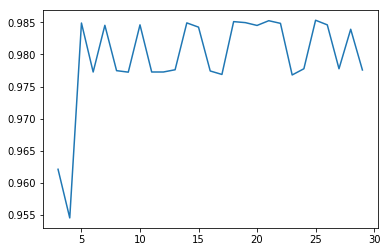

In [36]:
plt.plot(k_val, cv_scores)

cv k = 7 is the best k-fold

In [37]:
# baseline decision tree

In [38]:
clf = DecisionTreeClassifier()
clf.fit(X,y)
y_pred = clf.predict(X_validation)

In [39]:
print('null accuracy is {} '.format(y.value_counts().head(1)/len(y)))
print(metrics.accuracy_score(y_validation, y_pred))
print(metrics.recall_score(y_validation, y_pred, average =  'micro'))
print(metrics.precision_score(y_validation, y_pred, average='micro'))
print(metrics.f1_score(y_validation, y_pred, average='micro'))
#tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
#print('TN:{} | FP:{} | FN:{} | TP:{}'.format(tn, fp, fn, tp))
print(metrics.classification_report(y_validation, y_pred))

null accuracy is qpfs    0.393939
Name: device, dtype: float64 
1.0
1.0
1.0
1.0
                          precision    recall  f1-score   support

                     fbg       1.00      1.00      1.00        17
                    qpfs       1.00      1.00      1.00        23
ring_resonator_multimode       1.00      1.00      1.00        17

                accuracy                           1.00        57
               macro avg       1.00      1.00      1.00        57
            weighted avg       1.00      1.00      1.00        57



# decision tree with gridsearchCV

In [40]:
# # decision tree with grid search
# # create a pipeline
# pipe = make_pipeline(DecisionTreeClassifier())


# # search for an optimal splitter
# splitter_range = ['best','random']
                     
# # search or an optimal max_depth
# maxdepth_range = list(range(1,3))

# # search for an optimal minimum sample size
# samplesize_range = list(range(1,5))
                     
# # search for an optimal minimum sample leaf size
# sampleleaf_range = list(range(1,5))

# # search for an optimal of max_feature
# maxfeature_range = list(range(1,3))


# #create a param grid
# # param_grid = dict(decisiontree_classifier__max_depth= maxdepth_range, decisiontree_classifier__spitter= splitter_range, 
# #                   decisiontree_classifier__min_samples_split=samplesize_range , 
# #                   decisiontree_classifier__min_samples_leaf = sampleleaf_range, decisiontree_classifier__max_features = maxfeature_range)



# # create a grid search
# grid = GridSearchCV(pipe, param_grid, cv=7, scoring='f1_micro')
# i
# # fit the grid
# grid.fit(X, y)

# # view the best_score_ and best_params_
# print(grid.best_score_)
# print(grid.best_params_)



In [41]:
# run the model here

# decision tree with randomized search

In [42]:
# create a pipeline
pipe = make_pipeline(DecisionTreeClassifier())

# search for an optimal splitter
splitter_range = ['best','random']
                     
# search or an optimal max_depth
maxdepth_range = list(range(1,50))

# search for an optimal minimum sample size
samplesize_range = list(range(1,50))
                     
# search for an optimal minimum sample leaf size
sampleleaf_range = list(range(1,50))

# search for an optimal of max_feature
maxfeature_range = list(range(1,3))


# specify "parameter distributions"
param_dist = dict( splitter = splitter_range ,max_depth = maxdepth_range, min_samples_split=samplesize_range ,
                  min_samples_leaf = sampleleaf_range, max_features = maxfeature_range)

rand = RandomizedSearchCV(DecisionTreeClassifier(), param_dist, cv=5, scoring='f1_micro',
                          n_iter=28, random_state=5, return_train_score=True)
rand.fit(X, y)
rand.cv_results_

{'mean_fit_time': array([0.00372005, 0.00220022, 0.00200005, 0.00180001, 0.00311999,
        0.00311999, 0.        , 0.00311995, 0.00312004, 0.        ,
        0.00312004, 0.00311999, 0.        , 0.00311999, 0.00039997,
        0.00312004, 0.00311995, 0.00311995, 0.        , 0.        ,
        0.00311999, 0.00311999, 0.        , 0.00411997, 0.00411997,
        0.        , 0.        , 0.00312004]),
 'std_fit_time': array([6.05245094e-03, 4.00018706e-04, 9.53674316e-08, 9.79802753e-04,
        6.23998642e-03, 6.23998642e-03, 0.00000000e+00, 6.23989105e-03,
        6.24008179e-03, 0.00000000e+00, 6.24008179e-03, 6.23998642e-03,
        0.00000000e+00, 6.23998642e-03, 7.99942017e-04, 6.24008179e-03,
        6.23989105e-03, 6.23989105e-03, 0.00000000e+00, 0.00000000e+00,
        6.23998642e-03, 6.23998642e-03, 0.00000000e+00, 5.84786495e-03,
        5.84775813e-03, 0.00000000e+00, 0.00000000e+00, 6.24008179e-03]),
 'mean_score_time': array([0.00392008, 0.002     , 0.00200028, 0.00160007, 

In [43]:
# examine the best model
print(rand.best_score_)
print(rand.best_params_)

0.9547008547008546
{'splitter': 'best', 'min_samples_split': 21, 'min_samples_leaf': 4, 'max_features': 2, 'max_depth': 17}


In [44]:
dtree = DecisionTreeClassifier(splitter = 'best', min_samples_split = 30, min_samples_leaf = 12, 
                               max_features = 2, max_depth = 4)
dtree.fit(X,y)
y_pred = dtree.predict(X_validation)
print('null accuracy is {} '.format(y.value_counts().head(1)/len(y)))
print(metrics.accuracy_score(y_validation, y_pred))
print(metrics.recall_score(y_validation, y_pred, average =  'micro'))
print(metrics.precision_score(y_validation, y_pred, average='micro'))
print(metrics.f1_score(y_validation, y_pred, average='micro'))
#tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
#print('TN:{} | FP:{} | FN:{} | TP:{}'.format(tn, fp, fn, tp))
print(metrics.classification_report(y_validation, y_pred))


null accuracy is qpfs    0.393939
Name: device, dtype: float64 
1.0
1.0
1.0
1.0
                          precision    recall  f1-score   support

                     fbg       1.00      1.00      1.00        17
                    qpfs       1.00      1.00      1.00        23
ring_resonator_multimode       1.00      1.00      1.00        17

                accuracy                           1.00        57
               macro avg       1.00      1.00      1.00        57
            weighted avg       1.00      1.00      1.00        57



In [45]:
# create a pipeline
pipe = make_pipeline(DecisionTreeClassifier())

# search for an optimal splitter
splitter_range = ['best','random']
                     
# search or an optimal max_depth
maxdepth_range = list(range(1,50))

# search for an optimal minimum sample size
samplesize_range = list(range(1,50))
                     
# search for an optimal minimum sample leaf size
sampleleaf_range = list(range(1,50))

# search for an optimal of max_feature
maxfeature_range = list(range(2,3))


# specify "parameter distributions"
param_dist = dict( splitter = splitter_range ,max_depth = maxdepth_range, min_samples_split=samplesize_range ,
                  min_samples_leaf = sampleleaf_range, max_features = maxfeature_range)

rand = RandomizedSearchCV(DecisionTreeClassifier(), param_dist, cv=10, scoring='f1_micro',
                          n_iter=28, random_state=5, return_train_score=True)
rand.fit(X, y)
rand.cv_results_

{'mean_fit_time': array([0.00196004, 0.00156   , 0.00156002, 0.00312002, 0.        ,
        0.00156   , 0.00156   , 0.00311997, 0.00206003, 0.00156   ,
        0.00312002, 0.00156002, 0.00311997, 0.00311997, 0.00181   ,
        0.00175006, 0.00230999, 0.00156   , 0.00312002, 0.00156002,
        0.00311997, 0.00155997, 0.00230997, 0.00362005, 0.00099998,
        0.00312004, 0.00312002, 0.00156   ]),
 'std_fit_time': array([0.00461458, 0.00467999, 0.00468006, 0.00624003, 0.        ,
        0.00467999, 0.00467999, 0.00623994, 0.00462525, 0.00467999,
        0.00624003, 0.00468006, 0.00623994, 0.00623994, 0.0046567 ,
        0.00114569, 0.00456883, 0.00467999, 0.00624003, 0.00468006,
        0.00623994, 0.00467992, 0.00456883, 0.00606778, 0.00122471,
        0.00624008, 0.00624003, 0.00467999]),
 'mean_score_time': array([0.00196002, 0.00312002, 0.00311995, 0.        , 0.00312002,
        0.00311999, 0.00156   , 0.00322001, 0.00186002, 0.00311999,
        0.        , 0.00156002, 0.003120

In [46]:
# examine the best model
print(rand.best_score_)
print(rand.best_params_)

0.9697802197802199
{'splitter': 'best', 'min_samples_split': 30, 'min_samples_leaf': 20, 'max_features': 2, 'max_depth': 23}


In [47]:
dtree = DecisionTreeClassifier(splitter = 'best', min_samples_split = 45, min_samples_leaf = 2, 
                               max_features = 2, max_depth = 8)
dtree.fit(X,y)
y_pred = dtree.predict(X)
print(metrics.classification_report(y, dtree.predict(X)))

                          precision    recall  f1-score   support

                     fbg       0.97      1.00      0.98        32
                    qpfs       1.00      1.00      1.00        52
ring_resonator_multimode       1.00      0.98      0.99        48

                accuracy                           0.99       132
               macro avg       0.99      0.99      0.99       132
            weighted avg       0.99      0.99      0.99       132



In [48]:
feat_importance = dtree.tree_.compute_feature_importances(normalize=False)
features = dtree.tree_.feature[dtree.tree_.feature>=0] 
features

array([1, 0, 2], dtype=int64)

In [49]:
X.columns

Index(['q_scale', 'asym', 'num_peaks'], dtype='object')

# interpetation

# Run a SVM model

In [50]:
clf = svm.SVC(gamma = 'auto')
clf.fit(X, y)
y_pred = clf.predict(X_validation)


In [51]:
print('null accuracy is {} '.format(y.value_counts().head(1)/len(y)))
print(metrics.accuracy_score(y_validation, y_pred))
print(metrics.recall_score(y_validation, y_pred, average =  'micro'))
print(metrics.precision_score(y_validation, y_pred, average='micro'))
print(metrics.f1_score(y_validation, y_pred, average='micro'))
print(metrics.classification_report(y_validation, y_pred))

null accuracy is qpfs    0.393939
Name: device, dtype: float64 
1.0
1.0
1.0
1.0
                          precision    recall  f1-score   support

                     fbg       1.00      1.00      1.00        17
                    qpfs       1.00      1.00      1.00        23
ring_resonator_multimode       1.00      1.00      1.00        17

                accuracy                           1.00        57
               macro avg       1.00      1.00      1.00        57
            weighted avg       1.00      1.00      1.00        57



# NB model with peak characteristics as features

In [52]:
clf = GaussianNB()
clf.fit(X, y)
y_pred = clf.predict(X_validation)

In [53]:
print(metrics.classification_report(y_validation, y_pred))

                          precision    recall  f1-score   support

                     fbg       1.00      1.00      1.00        17
                    qpfs       1.00      1.00      1.00        23
ring_resonator_multimode       1.00      1.00      1.00        17

                accuracy                           1.00        57
               macro avg       1.00      1.00      1.00        57
            weighted avg       1.00      1.00      1.00        57



# Random Forest

In [54]:
clf = RandomForestClassifier()
clf.fit(X,y)
y_pred = clf.predict(X_validation)

In [55]:
print(metrics.classification_report(y_validation, y_pred))

                          precision    recall  f1-score   support

                     fbg       1.00      1.00      1.00        17
                    qpfs       1.00      1.00      1.00        23
ring_resonator_multimode       1.00      1.00      1.00        17

                accuracy                           1.00        57
               macro avg       1.00      1.00      1.00        57
            weighted avg       1.00      1.00      1.00        57



# Random Forest with optimization

In [ ]:
# cross-validation process using Pipeline

pipe = make_pipeline(RandomForestClassifier())
cv_scores =[]
k_val =[]
k_range = list(range(3,30))
for k in k_range:
    score = cross_val_score(pipe, X, y, cv=k, scoring='accuracy').mean()
    k_val.append(k)
    cv_scores.append(score)
ls = list(zip(k_val, cv_scores))
print(ls)

In [ ]:
# create a pipeline
pipe = make_pipeline(RandomForestClassifier())



# search for an optimal number of estimators
estimator_range = list(range(1,100))
                     
# search or an optimal max_depth
maxdepth_range = list(range(2,50))

# search for an optimal minimum sample leaf size
sampleleaf_range = list(range(2,50))

# search for max number of leaf nodes
maxleafnode_range = list(range(2,50))


# specify "parameter distributions"
param_dist = dict(n_estimators=estimator_range, max_depth = maxdepth_range, min_samples_leaf = sampleleaf_range,
                 max_leaf_nodes = maxleafnode_range)

rand = RandomizedSearchCV(RandomForestClassifier(), param_dist, cv=11, scoring='f1_micro',
                          random_state=5, return_train_score=True)
rand.fit(X, y)
rand.cv_results_

In [ ]:
# examine the best model
print(rand.best_score_)
print(rand.best_params_)

In [ ]:
rfor = RandomForestClassifier(n_estimators = 53, min_samples_leaf = 3, max_leaf_nodes = 31, 
                                max_depth = 46)
rfor.fit(X,y)
y_pred = rfor.predict(X_validation)
print('null accuracy is {} '.format(y.value_counts().head(1)/len(y)))
print(metrics.accuracy_score(y_validation, y_pred))
print(metrics.recall_score(y_validation, y_pred, average =  'micro'))
print(metrics.precision_score(y_validation, y_pred, average='micro'))
print(metrics.f1_score(y_validation, y_pred, average='micro'))
#tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
#print('TN:{} | FP:{} | FN:{} | TP:{}'.format(tn, fp, fn, tp))
print(metrics.classification_report(y_validation, y_pred))

# conclusion: 

the dataset used here is too simiplistic to draw any firm conclusions. basically the multi-FSR spectra is easy to tell apart from qpfs and fbg based on num_peaks feature. then you can differentiate between fbg adn qpfs basedon q_scale since those two are generally very different.

the complexity of problem will change once I can introduce single mode resonator data


space to run random forest model

# Testing out min processing of data 

hypothesis we can take the spectra and with no feature extraction use it to identify the sensor type. In this case we are going to "compress" the data into a pusedo-FFT spectra. In a way this process is closer to how you would train a new person. look at the characterisitics of the spectra 

#Run models with only the fft spectra columns

In [ ]:
# define the X and y axis
# X1 = df.drop(columns = ['device'])
X1 = df.iloc[:,:180]
y1 = df.device

X_testing, X_validation, y_testing, y_validation = train_test_split(X1,y1, test_size = 0.30, random_state=42)
X, y = X_testing, y_testing
X.shape

In [ ]:
X.head(1)

# Naives-Bayes Guasssian NB

In [ ]:
clf = GaussianNB()
clf.fit(X, y)
y_pred = clf.predict(X_validation)

In [ ]:
print(metrics.classification_report(y_validation, y_pred))

# Run a SVM model

In [ ]:
clf = svm.SVC(gamma = 'auto')
clf.fit(X, y)
y_pred = clf.predict(X_validation)

In [ ]:
print('null accuracy is {} '.format(y.value_counts().head(1)/len(y)))
print(metrics.accuracy_score(y_validation, y_pred))
print(metrics.recall_score(y_validation, y_pred, average =  'micro'))
print(metrics.precision_score(y_validation, y_pred, average='micro'))
print(metrics.f1_score(y_validation, y_pred, average='micro'))
print(metrics.classification_report(y_validation, y_pred))

# Run a Random KNN model

In [ ]:
clf =  KNeighborsClassifier()
clf.fit(X,y)
y_pred = clf.predict(X_validation)

In [ ]:
print(metrics.classification_report(y_validation, y_pred))

In [ ]:
# cross-validation process using Pipeline
from sklearn.model_selection import cross_val_score

pipe = make_pipeline(KNeighborsClassifier(n_neighbors=3))

cv_scores =[]
k_val =[]
k_range = list(range(3,30))
for k in k_range:
    score = cross_val_score(pipe, X, y, cv=k, scoring='accuracy').mean()
    k_val.append(k)
    cv_scores.append(score)
ls = list(zip(k_val, cv_scores))
print(ls)
# cross_val_score(pipe, X, y, cv=5, scoring='accuracy').mean()

In [ ]:
np.argmax(cv_scores)

In [ ]:
plt.plot(k_val, cv_scores)

In [ ]:
%time
# create a pipeline
pipe = make_pipeline(KNeighborsClassifier(n_neighbors=3))

# search for an optimal n_neighbors value using GridSearchCV
neighbors_range = list(range(2, 25))

# search or an optimal weigth parameter HOW DO I INTEGRATE THAT IN?
weight_range = ['uniform', 'distance']

# search for an optimal leaf size
leaf_range = list(range(1,50))

# search for an optimal metric range
metric_range = ['minkowski', 'manhattan']
#create a param grid
param_grid = dict(kneighborsclassifier__n_neighbors=neighbors_range,kneighborsclassifier__leaf_size=leaf_range,
                  kneighborsclassifier__metric=metric_range)

# create a grid search
grid = GridSearchCV(pipe, param_grid, cv=10, scoring='f1_micro')
i
# fit the grid
grid.fit(X, y)

# view the best_score_ and best_params_
print(grid.best_score_)
print(grid.best_params_)

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 2, metric = 'minkowski', leaf_size = 1, weights='distance')
knn.fit(X,y)
y_pred = knn.predict(X_validation)
print('null accuracy is {} '.format(y.value_counts().head(1)/len(y)))
print(metrics.accuracy_score(y_validation, y_pred))
print(metrics.recall_score(y_validation, y_pred, average =  'micro'))
print(metrics.precision_score(y_validation, y_pred, average='micro'))
print(metrics.f1_score(y_validation, y_pred, average='micro'))
#tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
#print('TN:{} | FP:{} | FN:{} | TP:{}'.format(tn, fp, fn, tp))
print(metrics.classification_report(y_validation, y_pred))
%time

# Decision Tree

In [ ]:
# baseline decision tree

In [ ]:
clf = DecisionTreeClassifier()
clf.fit(X,y)
y_pred = clf.predict(X_validation)

In [ ]:
y_pred = knn.predict(X_validation)
print('null accuracy is {} '.format(y.value_counts().head(1)/len(y)))
print(metrics.accuracy_score(y_validation, y_pred))
print(metrics.recall_score(y_validation, y_pred, average =  'micro'))
print(metrics.precision_score(y_validation, y_pred, average='micro'))
print(metrics.f1_score(y_validation, y_pred, average='micro'))
#tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
#print('TN:{} | FP:{} | FN:{} | TP:{}'.format(tn, fp, fn, tp))
print(metrics.classification_report(y_validation, y_pred))

In [ ]:
# cross-validation process using Pipeline
from sklearn.model_selection import cross_val_score

pipe = make_pipeline(DecisionTreeClassifier())
cv_scores =[]
k_val =[]
k_range = list(range(3,30))
for k in k_range:
    score = cross_val_score(pipe, X, y, cv=k, scoring='accuracy').mean()
    k_val.append(k)
    cv_scores.append(score)
ls = list(zip(k_val, cv_scores))
print(ls)

In [ ]:
np.argmax(cv_scores)

In [ ]:
plt.plot(k_val, cv_scores)

# run decision tree 

In [ ]:
# create a pipeline
pipe = make_pipeline(DecisionTreeClassifier())

# search for an optimal splitter
splitter_range = ['best','random']
                     
# search or an optimal max_depth
maxdepth_range = list(range(1,50))

# search for an optimal minimum sample size
samplesize_range = list(range(1,50))
                     
# search for an optimal minimum sample leaf size
sampleleaf_range = list(range(1,50))

# search for an optimal of max_feature
maxfeature_range = list(range(1,3))


# specify "parameter distributions"
param_dist = dict( splitter = splitter_range ,max_depth = maxdepth_range, min_samples_split=samplesize_range ,
                  min_samples_leaf = sampleleaf_range, max_features = maxfeature_range)

rand = RandomizedSearchCV(DecisionTreeClassifier(), param_dist, cv=10, scoring='f1_micro',
                          n_iter=28, random_state=5, return_train_score=True)
rand.fit(X, y)
rand.cv_results_

In [ ]:
# examine the best model
print(rand.best_score_)
print(rand.best_params_)

In [ ]:
tree = DecisionTreeClassifier(splitter = 'best', min_samples_split = 21, min_samples_leaf = 4, 
                               max_features = 2, max_depth = 17)
dtree.fit(X,y)
y_pred = dtree.predict(X_validation)
print('null accuracy is {} '.format(y.value_counts().head(1)/len(y)))
print(metrics.accuracy_score(y_validation, y_pred))
print(metrics.recall_score(y_validation, y_pred, average =  'micro'))
print(metrics.precision_score(y_validation, y_pred, average='micro'))
print(metrics.f1_score(y_validation, y_pred, average='micro'))
#tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
#print('TN:{} | FP:{} | FN:{} | TP:{}'.format(tn, fp, fn, tp))
print(metrics.classification_report(y_validation, y_pred))

# Random Forest model

#    not optimized

In [ ]:
clf = RandomForestClassifier()
clf.fit(X,y)
y_pred = clf.predict(X_validation)

In [ ]:
print(metrics.classification_report(y_validation, y_pred))

In [ ]:
# cross-validation process using Pipeline

pipe = make_pipeline(RandomForestClassifier())
cv_scores =[]
k_val =[]
k_range = list(range(3,30))
for k in k_range:
    score = cross_val_score(pipe, X, y, cv=k, scoring='accuracy').mean()
    k_val.append(k)
    cv_scores.append(score)
ls = list(zip(k_val, cv_scores))
print(ls)

In [ ]:
plt.plot(k_val, cv_scores)

In [ ]:
# create a pipeline
pipe = make_pipeline(RandomForestClassifier())



# search for an optimal number of estimators
estimator_range = list(range(1,100))
                     
# search or an optimal max_depth
maxdepth_range = list(range(2,50))

# search for an optimal minimum sample leaf size
sampleleaf_range = list(range(2,50))

# search for max number of leaf nodes
maxleafnode_range = list(range(2,50))


# specify "parameter distributions"
param_dist = dict(n_estimators=estimator_range, max_depth = maxdepth_range, min_samples_leaf = sampleleaf_range,
                 max_leaf_nodes = maxleafnode_range)

rand = RandomizedSearchCV(RandomForestClassifier(), param_dist, cv=14, scoring='f1_micro',
                          random_state=5, return_train_score=True)
rand.fit(X, y)
rand.cv_results_

In [ ]:
# examine the best model
print(rand.best_score_)
print(rand.best_params_)

In [ ]:
rfor = RandomForestClassifier(n_estimators = 53, min_samples_leaf = 3, max_leaf_nodes = 31, 
                                max_depth = 46)
rfor.fit(X,y)
y_pred = rfor.predict(X_validation)
print('null accuracy is {} '.format(y.value_counts().head(1)/len(y)))
print(metrics.accuracy_score(y_validation, y_pred))
print(metrics.recall_score(y_validation, y_pred, average =  'micro'))
print(metrics.precision_score(y_validation, y_pred, average='micro'))
print(metrics.f1_score(y_validation, y_pred, average='micro'))
#tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
#print('TN:{} | FP:{} | FN:{} | TP:{}'.format(tn, fp, fn, tp))
print(metrics.classification_report(y_validation, y_pred))

#Conclusions